## Курсовая работа по курсу "Видеокурс от Мегафона"(Гикбрейнс).

**Оглавление**
* Разделы:
    * [0. Загрузка и подготовка данных](#load)
    * [1. Просмотр, анализ данных, базовая модель](#analys) 
         * [1.1 Модель на первоначальных данных train](#train1)
         * [1.2 Модель на первоначальных данных train и профиле потребления клиента](#train2)
         * [1.3 Модель на профиле потребления клиента](#train3)
         * [1.4 Модель на первоначальных данных train и профиле потребления клиента в разбивке по предлагаемым услугам](#train4)
         * [1.5 Модель на первоначальных данных train в разбивке по неповторяющимся и повторяющимся id (повторные предложения тех же услуг)](#train5)
         * [1.6 Модель на первоначальных данных train и сэмплирование классов](#train6)     
    * [2. Подбор гиперпараметров модели](#hyper)
    * [3. Сохранение модели, прогноз на тестовой выборке](#train_save)


### Загрузка и подготовка данных <a class='anchor' id='load'>

Задача:

У нас появился запрос из отдела продаж и маркетинга. Как вы знаете «МегаФон» предлагает обширный набор различных услуг своим абонентам. При этом разным пользователям интересны разные услуги. Поэтому необходимо построить  алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.

В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.
Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.
Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц. 

Итого, в качестве входных данных будут представлены:
●	data_train.csv: id, vas_id, buy_time, target
●	features.csv.zip: id, <feature_list> 

И тестовый набор:
●	data_test.csv: id, vas_id, buy_time

target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 
buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.
id - идентификатор абонента
vas_id - подключаемая услуга
Примечание: Размер файла features.csv в распакованном виде весит 20 гб, для работы  с ним можно воспользоваться pandas.read_csv, либо можно воспользоваться библиотекой Dask.


Скоринг будет осуществляться функцией f1, невзвешенным образом, как например делает функция sklearn.metrics.f1_score(…, average=’macro’).


In [1]:
from tqdm import tqdm
import time
import os
from pathlib import Path
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted

# plt.style.use('fivethirtyeight')
# %config InlineBackend.figure_format = 'svg'
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, accuracy_score, \
                            classification_report, plot_confusion_matrix, plot_precision_recall_curve, \
                            precision_recall_curve, plot_roc_curve)

import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.model_selection import train_test_split

import vaex
import blake3
# https://vaex.io/docs/index.html

# !pip install vaex
# pip install blake3==0.2.1  (использовать pip без !  <---- иначе не будет нормально работать vaex "blake3.__new__() error")
# !pip install --upgrade pandas


#!pip install catboost
# conda install scikit-learn
# !pip install scikit-learn==0.22
# !pip install bayesian-optimization
from bayes_opt import BayesianOptimization

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))
    return df


def get_classification_report(y_train_true, y_train_pred_proba, y_test_true, y_test_pred_proba, threshold=0.5):
    y_train_pred = y_train_pred_proba > threshold
    y_test_pred = y_test_pred_proba > threshold
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    
    
def show_proba_calibration_plots(y_predicted_probs, y_true_labels, focus):
    preds_with_true_labels = np.array(
        list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold)), average='macro'))

    scores_table = pd.DataFrame({'f1': f1_scores,
                                 'precision': precisions,
                                 'recall': recalls,
                                 'probability': thresholds}).sort_values('f1', ascending=False).round(4)

    thresholds2 = []
    precisions2 = []
    recalls2 = []
    f1_scores2 = []

    for threshold2 in np.linspace(focus-0.015, focus+0.015, 15):
        thresholds2.append(threshold2)
        precisions2.append(precision_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold2))))
        recalls2.append(recall_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold2))))
        f1_scores2.append(f1_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold2)), average='macro'))

    scores_table2 = pd.DataFrame({'f1': f1_scores2,
                                  'precision': precisions2,
                                  'recall': recalls2,
                                  'probability': thresholds2}).sort_values('f1', ascending=False).round(3)
    maxf1_proba = scores_table2.iloc[0, 3]

    figure = plt.figure(figsize=(15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.plot((maxf1_proba, maxf1_proba), (0, 1), 'g--')
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))
    plt1.table(cellText=scores_table.values,
               colLabels=scores_table.columns,
               colLoc='center', cellLoc='center', loc='bottom', bbox=[0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0],
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0],
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))
    plt2.table(cellText=scores_table2.values,
               colLabels=scores_table2.columns,
               colLoc='center', cellLoc='center', loc='bottom', bbox=[0, -1.3, 1, 1])
    plt.savefig('proba_calibration.png')
    plt.show()
    return maxf1_proba

In [ ]:
# СЛЕДУЮЩИЕ ДЕЙСТВИЯ МОЖНО НЕ ВЫПОЛНЯТЬ И СКАЧАТЬ УЖЕ ГОТОВЫЙ(КОТОРЫЙ ПРЕОБРАЗОВАН ДАЛЕЕ В КОДЕ) ДАТАСЕТ df ПО ССЫЛКЕ:
# https://disk.yandex.ru/d/VJWttTIHbtKjAg

In [ ]:
# При выполнении следующих действий необходимо иметь свободное место на жестком диске.Процесс выполнения длительный(до получаса)

In [ ]:
# Открыть часть данных

# Файл доступен по ссылке:
# https://drive.google.com/file/d/1d7ICyzw3OoY3OCJ5MZ0MXzsZ1hF7zdD9/view?usp=sharing

feature_chunk = pd.read_csv(r'G:\features\features.csv', chunksize=10, sep='\t')

In [ ]:
# Преобразовать данные и разделить на части
stop_flag = 0
counter = 0
chunk = 500000

while stop_flag == 0:
    # Сохранить в переменную
    tmp_f_chunk = feature_chunk.get_chunk(chunk).drop('Unnamed: 0', axis=1)
    
    tmp_f_reduce = reduce_mem_usage(tmp_f_chunk)
    
    tmp_f_reduce.to_csv(f'features_part{counter}.csv', index=True)
    counter += 1
    print(len(tmp_f_reduce))
    
    if len(tmp_f_reduce) < chunk:
        stop_flag = 1

In [ ]:
%%time
# Откроем все части сразу

# df = vaex.open('features_part*.csv', convert='bigdata_megaf.hdf5')
# df_vaex = vaex.from_csv('features_part*.csv', copy_index=False)
df_vaex = vaex.open('features_part*.csv')
df_vaex

In [ ]:
train = pd.read_csv('data_train.csv').drop('Unnamed: 0', axis=1)
test = pd.read_csv('data_test.csv').drop('Unnamed: 0', axis=1)

In [ ]:
train_list_id = train.id.unique().tolist()

In [ ]:
%%time
df_vaex_train_id = df_vaex[df_vaex['id'].isin(train_list_id)]
df_vaex_train_id

In [ ]:
%%time
df_pandas = reduce_mem_usage( df_vaex_train_id.to_pandas_df([i for i in df_vaex[df_vaex['id'].isin(train_list_id)].columns]) )
df_pandas

In [ ]:
df_pandas.info()

In [ ]:
%%time
df = pd.merge(train.rename(columns={'buy_time': 'buy_time_start'}),
              df_pandas.rename(columns={'buy_time': 'buy_time_offer'}), on='id', how='left')
df

In [ ]:
df.to_csv('df.csv', index=False)

### Просмотр, анализ данных, базовая модель <a class='anchor' id='analys'>

In [3]:
%%time
df = reduce_mem_usage(pd.read_csv('df.csv'))

Memory usage of dataframe is 1699.47 MB
Memory usage after optimization is: 849.74 MB
Decreased by 50.0%
Wall time: 2min 31s


In [4]:
# Запустить, если выполнение тетрадки осуществляется с данного блока (просмотр и анализ данных)
train = pd.read_csv('data_train.csv').drop('Unnamed: 0', axis=1)
test = pd.read_csv('data_test.csv').drop('Unnamed: 0', axis=1)

In [5]:
df['target'].value_counts()

0.0    797845
1.0     62207
Name: target, dtype: int64

In [6]:
df

,id,vas_id,buy_time_start,target,Unnamed: 0,buy_time_offer,0,1,2,3,...,243,244,245,246,247,248,249,250,251,252
0,540968,8.0,1537131600,0.0,3756522,1541970000,-31.559971,327.360901,-45.500786,274.753204,...,-845.373840,-613.770813,-20.996269,-37.630447,-28.747725,4.167111,7.305572,-12.175933,21.543859,0.0
1,1454121,4.0,1531688400,0.0,2735973,1531083600,547.270020,238.430893,533.329224,274.803192,...,-972.373840,-613.770813,-25.996269,-19.630449,-278.747711,-24.832888,-0.694429,-11.175933,-0.456140,0.0
2,2458816,1.0,1534107600,0.0,3586550,1543179600,-92.139969,-95.469109,-106.080788,-139.596802,...,-977.373840,-613.770813,-25.996269,-37.630447,-304.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.0
3,3535012,5.0,1535922000,0.0,1634974,1533502800,54.880028,12.970888,54.079212,-9.116798,...,-977.373840,-613.770813,-25.996269,-18.630449,-133.747726,-14.832889,-0.694429,-1.175933,-0.456140,0.0
4,1693214,1.0,1535922000,0.0,716515,1543179600,45.160030,295.240875,64.679214,344.283203,...,-965.373840,-612.770813,-22.996269,-32.630447,-127.747726,-4.832889,-0.694429,-12.175933,-0.456140,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860047,3812226,2.0,1546203600,0.0,3598646,1532898000,29.750029,6.200888,24.279215,-37.936798,...,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.0
860048,2480469,2.0,1546203600,0.0,1126545,1532293200,-89.179970,-56.499111,-103.120789,-109.106796,...,-66.373848,-321.770782,-25.996269,62.369553,1167.252319,41.167110,-0.694429,54.824066,-0.456140,0.0
860049,158236,2.0,1546203600,0.0,3755060,1538946000,-96.799973,62.140888,-110.740784,9.533202,...,-683.373840,-470.770782,-25.996269,-37.630447,99.252274,178.167114,-0.694429,191.824066,-0.456140,0.0
860050,1825525,2.0,1546203600,0.0,253884,1533502800,-96.799973,-81.919113,-110.740784,-128.596802,...,1018.626160,1367.229248,-24.996269,-35.630447,-237.747726,-21.832888,-0.694429,-8.175933,-0.456140,1.0


In [7]:
train

,id,vas_id,buy_time,target
0,540968,8.0,1537131600,0.0
1,1454121,4.0,1531688400,0.0
2,2458816,1.0,1534107600,0.0
3,3535012,5.0,1535922000,0.0
4,1693214,1.0,1535922000,0.0
...,...,...,...,...
831648,3812226,2.0,1546203600,0.0
831649,2480469,2.0,1546203600,0.0
831650,158236,2.0,1546203600,0.0
831651,1825525,2.0,1546203600,0.0


In [8]:
train['id'].nunique()

806613

In [9]:
df.describe()

,id,vas_id,buy_time_start,target,Unnamed: 0,buy_time_offer,0,1,2,3,...,243,244,245,246,247,248,249,250,251,252
count,8.600520e+05,860052.000000,8.600520e+05,860052.000000,8.600520e+05,8.600520e+05,860052.000000,860052.000000,860052.000000,860052.000000,...,860052.000000,860052.000000,860052.000000,860052.000000,860052.000000,860052.000000,860052.000000,860052.000000,860052.000000,860052.000000
mean,2.158835e+06,2.686381,1.538934e+09,0.072329,2.255048e+06,1.539584e+09,0.104171,0.450818,-0.005132,0.567611,...,-0.687326,-1.618469,0.377723,-0.174421,-2.500844,-0.155110,-0.030566,0.020310,0.003240,0.257708
std,1.257637e+06,1.951954,5.019203e+06,0.258298,1.302793e+06,5.319503e+06,296.265442,486.561859,302.882080,550.747864,...,3210.200195,2223.547607,1348.556641,298.554382,1286.812622,262.114594,8.087867,201.579285,11.545439,2.053706
min,2.000000e+00,1.000000,1.531084e+09,0.000000,1.300000e+01,1.531084e+09,-1151.890015,-1594.119141,-2651.840820,-1634.436768,...,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.000000
25%,1.068654e+06,1.000000,1.534108e+09,0.000000,1.126285e+06,1.534712e+09,-96.799973,-209.519119,-110.740784,-243.156799,...,-977.373840,-613.770813,-25.996269,-37.630447,-305.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.000000
50%,2.144769e+06,2.000000,1.538341e+09,0.000000,2.253748e+06,1.539551e+09,-84.949974,-60.719112,-85.310783,-79.426796,...,-959.373840,-613.770813,-25.996269,-37.630447,-239.747726,-23.832888,-0.694429,-12.175933,-0.456140,0.000000
75%,3.245932e+06,4.000000,1.544389e+09,0.000000,3.382943e+06,1.544994e+09,11.670030,119.130890,27.249214,127.003204,...,-487.373840,-408.770782,-24.996269,-33.630447,-78.747726,-10.832889,-0.694429,-9.175933,-0.456140,1.000000
max,4.362694e+06,9.000000,1.546204e+09,1.000000,4.512521e+06,1.548018e+09,211730.718750,212606.125000,211716.781250,213357.750000,...,240076.625000,145602.234375,980158.000000,47086.371094,185850.250000,138539.171875,3865.305664,138552.828125,9489.543945,1743.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860052 entries, 0 to 860051
Columns: 259 entries, id to 252
dtypes: float32(255), int32(4)
memory usage: 849.7 MB


#### Модель на первоначальных данных train <a class='anchor' id='train1'>

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(train.drop('target', axis=1), train['target'], 
                                                    shuffle=True,
                                                    test_size=0.4,
                                                    random_state=99,
                                                    stratify=train['target']
                                                   )

In [12]:
# disbalance = train['target'].value_counts()[0] / train['target'].value_counts()[1]
# disbalance

In [13]:
cb_params = {
    "n_estimators": 1000,
#     "loss_function": "Logloss",
    "eval_metric": "F1",
#     "task_type": "CPU",
#     "max_bin": 20,
#     "verbose": 25,
#     "max_depth": 6,
#     "l2_leaf_reg": 100,
    "early_stopping_rounds": 100,
#     "thread_count": 6,
    "random_seed": 42,
#     "importance_type": 'macro'
}

In [14]:
model_ctb = CatBoostClassifier(**cb_params)
model_ctb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=100)

Learning rate set to 0.147007
0:	learn: 0.0484914	test: 0.0484914	test1: 0.0501575	best: 0.0501575 (0)	total: 199ms	remaining: 3m 19s
100:	learn: 0.3978490	test: 0.3978490	test1: 0.3921337	best: 0.3921453 (78)	total: 9.2s	remaining: 1m 21s
200:	learn: 0.4052176	test: 0.4052176	test1: 0.3930891	best: 0.3949952 (132)	total: 17.9s	remaining: 1m 11s
300:	learn: 0.4085173	test: 0.4085173	test1: 0.3933148	best: 0.3950480 (222)	total: 26.7s	remaining: 1m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3950479981
bestIteration = 222

Shrink model to first 223 iterations.


In [15]:
y_pred_cb_train = model_ctb.predict_proba(X_train)[:,1]
y_pred_cb_valid = model_ctb.predict_proba(X_valid)[:,1]

print(f" {get_classification_report(y_train,y_pred_cb_train, y_valid, y_pred_cb_valid, threshold=0.5)}")

TRAIN

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    462879
         1.0       0.68      0.29      0.41     36112

    accuracy                           0.94    498991
   macro avg       0.81      0.64      0.69    498991
weighted avg       0.93      0.94      0.93    498991

TEST

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    308588
         1.0       0.67      0.28      0.40     24074

    accuracy                           0.94    332662
   macro avg       0.81      0.63      0.68    332662
weighted avg       0.93      0.94      0.93    332662

 None


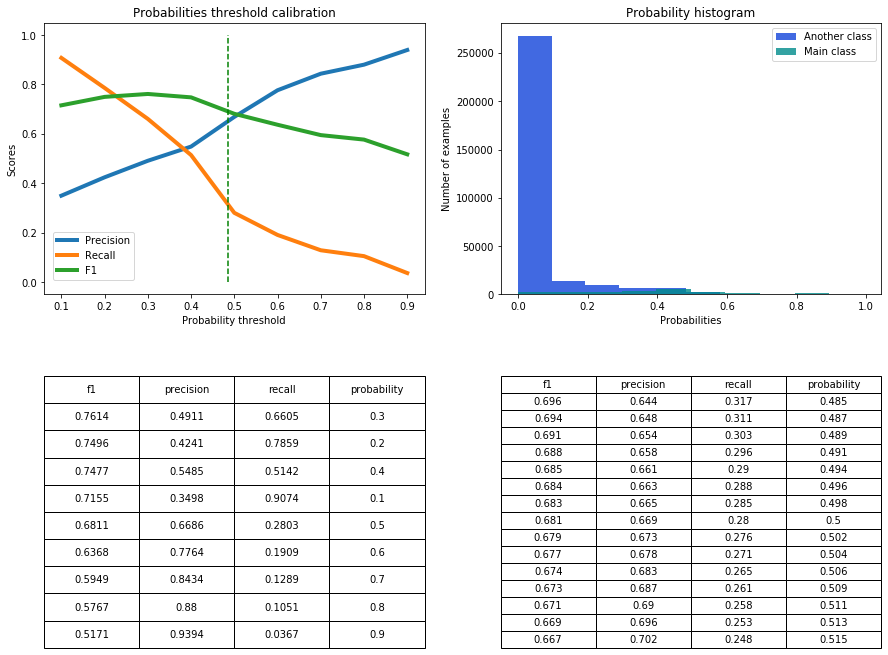

Wall time: 26.7 s


0.485

In [16]:
%%time
show_proba_calibration_plots(y_pred_cb_valid, y_valid, focus=0.5)

In [17]:
# Линейная модель

In [18]:
%%time
model_lasso = Lasso()

model_lasso.fit(X_train, y_train)

y_pred_lasso_train = model_lasso.predict(X_train)
y_pred_lasso_valid = model_lasso.predict(X_valid)

print(f" {get_classification_report(y_train, y_pred_lasso_train, y_valid, y_pred_lasso_valid, threshold=0.1)}")

TRAIN

              precision    recall  f1-score   support

         0.0       0.95      0.71      0.82    462879
         1.0       0.13      0.55      0.21     36112

    accuracy                           0.70    498991
   macro avg       0.54      0.63      0.51    498991
weighted avg       0.89      0.70      0.77    498991

TEST

              precision    recall  f1-score   support

         0.0       0.95      0.71      0.81    308588
         1.0       0.13      0.54      0.21     24074

    accuracy                           0.70    332662
   macro avg       0.54      0.63      0.51    332662
weighted avg       0.89      0.70      0.77    332662

 None
Wall time: 1.94 s


In [19]:
model_ridge = Ridge()
model_ridge.fit(X_train, y_train)

y_pred_ridge_train = model_ridge.predict(X_train)
y_pred_ridge_valid = model_ridge.predict(X_valid)

print(f" {get_classification_report(y_train, y_pred_ridge_train, y_valid, y_pred_ridge_valid, threshold=0.2)}")

TRAIN

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94    462879
         1.0       0.26      0.26      0.26     36112

    accuracy                           0.89    498991
   macro avg       0.60      0.60      0.60    498991
weighted avg       0.89      0.89      0.89    498991

TEST

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94    308588
         1.0       0.26      0.26      0.26     24074

    accuracy                           0.89    332662
   macro avg       0.60      0.60      0.60    332662
weighted avg       0.89      0.89      0.89    332662

 None


#### Модель на первоначальных данных train и профиле потребления клиента <a class='anchor' id='train2'>

In [20]:
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(df.drop('target', axis=1), df['target'], 
                                                    shuffle=True,
                                                    test_size=0.4,
                                                    random_state=99,
                                                    stratify=df['target']
                                                   )

In [21]:
model_ctb2 = CatBoostClassifier(**cb_params)
model_ctb2.fit(X_train2, y_train2, eval_set=[(X_train2, y_train2), (X_valid2, y_valid2)], verbose=100)

Learning rate set to 0.148231
0:	learn: 0.0000000	test: 0.0000000	test1: 0.0000000	best: 0.0000000 (0)	total: 233ms	remaining: 3m 52s
100:	learn: 0.4014028	test: 0.4014028	test1: 0.3966834	best: 0.3966834 (99)	total: 21.5s	remaining: 3m 11s
200:	learn: 0.4171629	test: 0.4171629	test1: 0.3967795	best: 0.3984890 (131)	total: 40.9s	remaining: 2m 42s
300:	learn: 0.4370646	test: 0.4370646	test1: 0.4019155	best: 0.4022071 (296)	total: 1m	remaining: 2m 21s
400:	learn: 0.4545505	test: 0.4545505	test1: 0.4032433	best: 0.4045908 (388)	total: 1m 20s	remaining: 1m 59s
500:	learn: 0.4686509	test: 0.4686509	test1: 0.4031658	best: 0.4048590 (489)	total: 1m 40s	remaining: 1m 39s
600:	learn: 0.4840081	test: 0.4840081	test1: 0.4068395	best: 0.4071962 (595)	total: 1m 59s	remaining: 1m 19s
700:	learn: 0.4969371	test: 0.4969371	test1: 0.4054017	best: 0.4080556 (667)	total: 2m 20s	remaining: 59.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.408055609
bestIteration = 667

Shrink mode

In [22]:
y_pred_cb_train2 = model_ctb2.predict_proba(X_train2)[:,1]
y_pred_cb_valid2 = model_ctb2.predict_proba(X_valid2)[:,1]

print(f" {get_classification_report(y_train2, y_pred_cb_train2, y_valid2, y_pred_cb_valid2, threshold=0.5)}")

TRAIN

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    478707
         1.0       0.76      0.36      0.49     37324

    accuracy                           0.95    516031
   macro avg       0.86      0.68      0.73    516031
weighted avg       0.94      0.95      0.94    516031

TEST

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    319138
         1.0       0.64      0.30      0.41     24883

    accuracy                           0.94    344021
   macro avg       0.80      0.64      0.69    344021
weighted avg       0.93      0.94      0.93    344021

 None


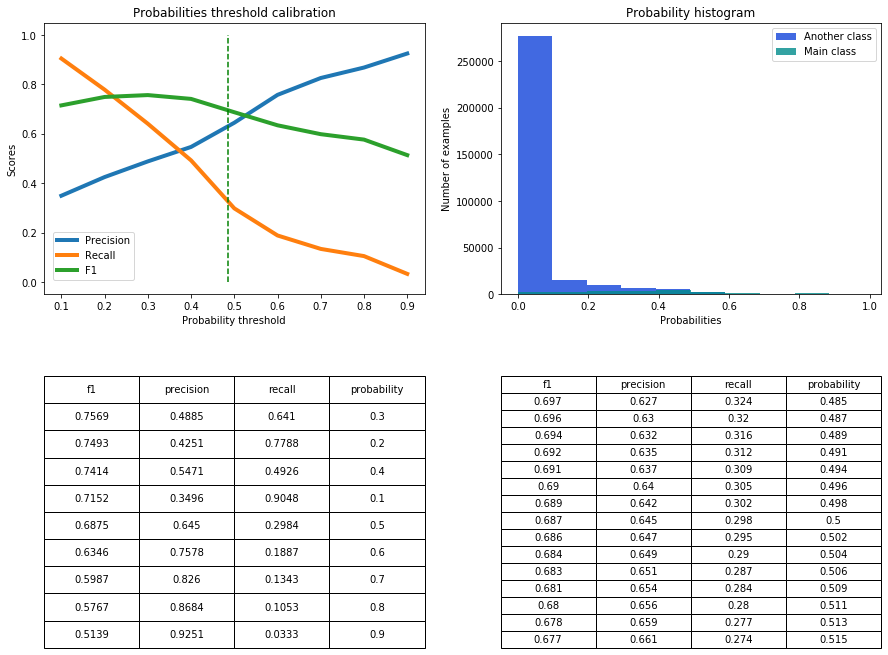

Wall time: 27.3 s


0.485

In [23]:
%%time
show_proba_calibration_plots(y_pred_cb_valid2, y_valid2, focus=0.5)

#### Модель на профиле потребления клиента <a class='anchor' id='train3'>

In [24]:
X_train3, X_valid3, y_train3, y_valid3 = train_test_split(df.drop(['target', 'vas_id', 'buy_time_start'], axis=1),
                                                          df['target'], 
                                                    shuffle=True,
                                                    test_size=0.4,
                                                    random_state=99,
                                                    stratify=df['target']
                                                   )

In [25]:
model_ctb3 = CatBoostClassifier(**cb_params)
model_ctb3.fit(X_train3, y_train3, eval_set=[(X_train3, y_train3), (X_valid3, y_valid3)], verbose=100)

Learning rate set to 0.148231
0:	learn: 0.0000000	test: 0.0000000	test1: 0.0000000	best: 0.0000000 (0)	total: 211ms	remaining: 3m 30s
100:	learn: 0.0001607	test: 0.0001607	test1: 0.0000000	best: 0.0000000 (0)	total: 20s	remaining: 2m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.


In [27]:
# Из результатов модели видно, что данные о профиле потребления клиента(все 252 признака) не дают какого-либо 
#  прироста информации для "деревянной" модели.

In [28]:
%%time
model_lasso = Lasso()

model_lasso.fit(X_train3, y_train3)

Wall time: 10.1 s


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [29]:
y_pred_lasso_train = model_lasso.predict(X_train3)
y_pred_lasso_valid = model_lasso.predict(X_valid3)

print(f" {get_classification_report(y_train3, y_pred_lasso_train, y_valid3, y_pred_lasso_valid, threshold=0.5)}")

TRAIN

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    478707
         1.0       0.00      0.00      0.00     37324

    accuracy                           0.93    516031
   macro avg       0.46      0.50      0.48    516031
weighted avg       0.86      0.93      0.89    516031

TEST

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    319138
         1.0       0.00      0.00      0.00     24883

    accuracy                           0.93    344021
   macro avg       0.46      0.50      0.48    344021
weighted avg       0.86      0.93      0.89    344021

 None


#### Модель на первоначальных данных train и профиле потребления клиента в разбивке по предлагаемым услугам <a class='anchor' id='train4'>

In [30]:
np.sort(df.vas_id.unique())

array([1., 2., 4., 5., 6., 7., 8., 9.], dtype=float32)

Learning rate set to 0.116179
0:	learn: 0.0000000	test: 0.0000000	test1: 0.0000000	best: 0.0000000 (0)	total: 169ms	remaining: 2m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3977900552
bestIteration = 161

Shrink model to first 162 iterations.
Разбивка по услуге № 1.0 (отсечка 0.5) -------------->


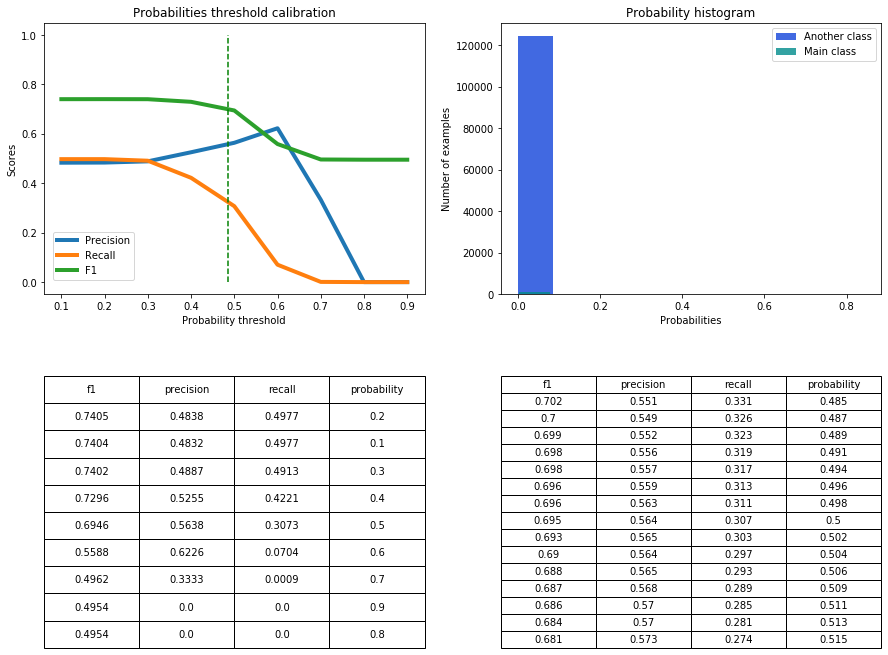

Learning rate set to 0.110103
0:	learn: 0.0006714	test: 0.0006714	test1: 0.0000000	best: 0.0000000 (0)	total: 81.6ms	remaining: 1m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5868493151
bestIteration = 60

Shrink model to first 61 iterations.
Разбивка по услуге № 2.0 (отсечка 0.5) -------------->


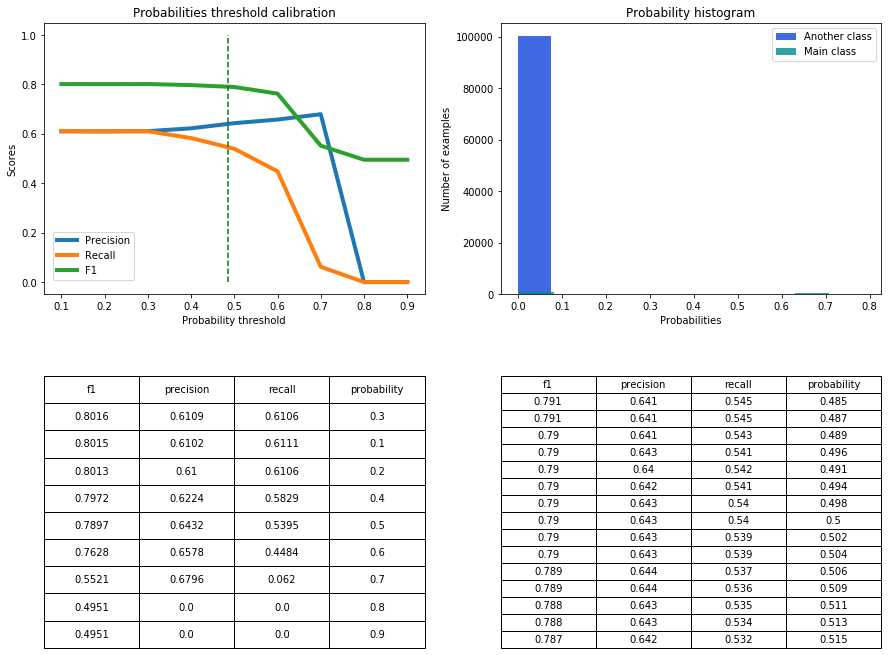

Learning rate set to 0.084589
0:	learn: 0.3958611	test: 0.3958611	test1: 0.3845118	best: 0.3845118 (0)	total: 41.4ms	remaining: 41.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3845117845
bestIteration = 0

Shrink model to first 1 iterations.
Разбивка по услуге № 4.0 (отсечка 0.5) -------------->


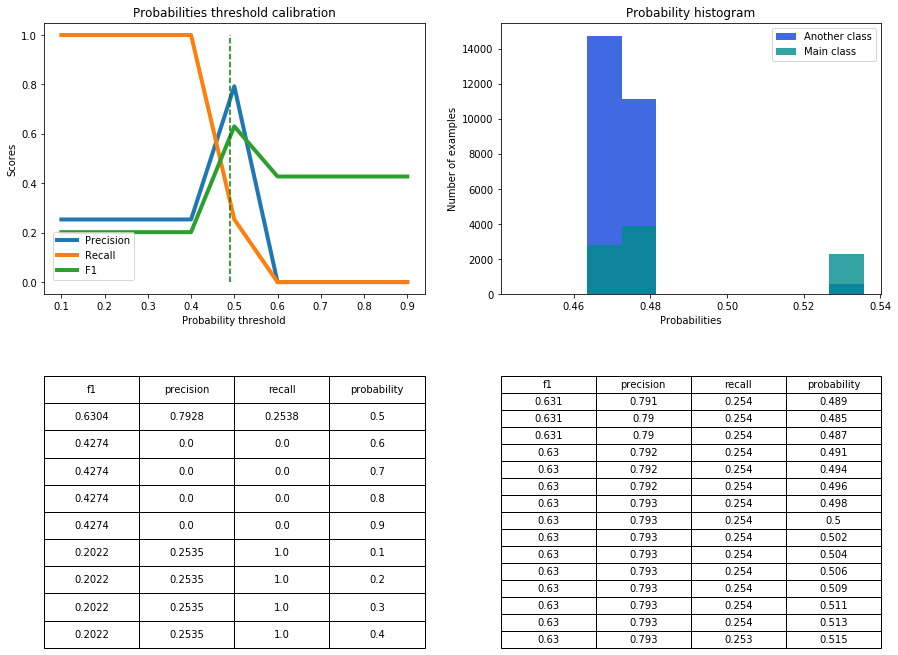

Learning rate set to 0.086507
0:	learn: 0.0000000	test: 0.0000000	test1: 0.0000000	best: 0.0000000 (0)	total: 38.7ms	remaining: 38.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.620432513
bestIteration = 131

Shrink model to first 132 iterations.
Разбивка по услуге № 5.0 (отсечка 0.5) -------------->


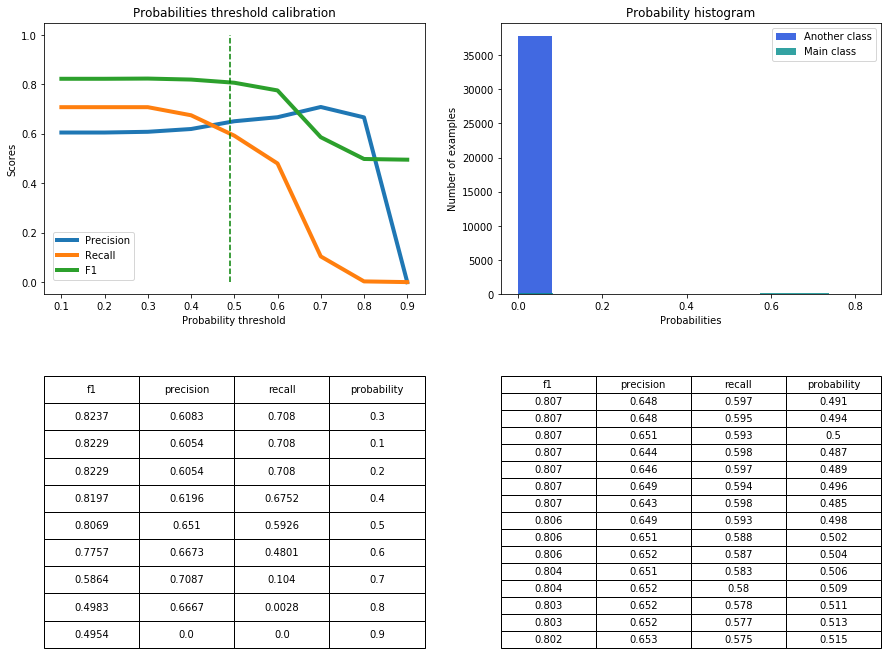

Learning rate set to 0.076749
0:	learn: 0.1159971	test: 0.1159971	test1: 0.1143277	best: 0.1143277 (0)	total: 41.7ms	remaining: 41.7s
999:	learn: 0.7138570	test: 0.7138570	test1: 0.3561981	best: 0.3565691 (996)	total: 30s	remaining: 0us

bestTest = 0.3565690593
bestIteration = 996

Shrink model to first 997 iterations.
Разбивка по услуге № 6.0 (отсечка 0.5) -------------->


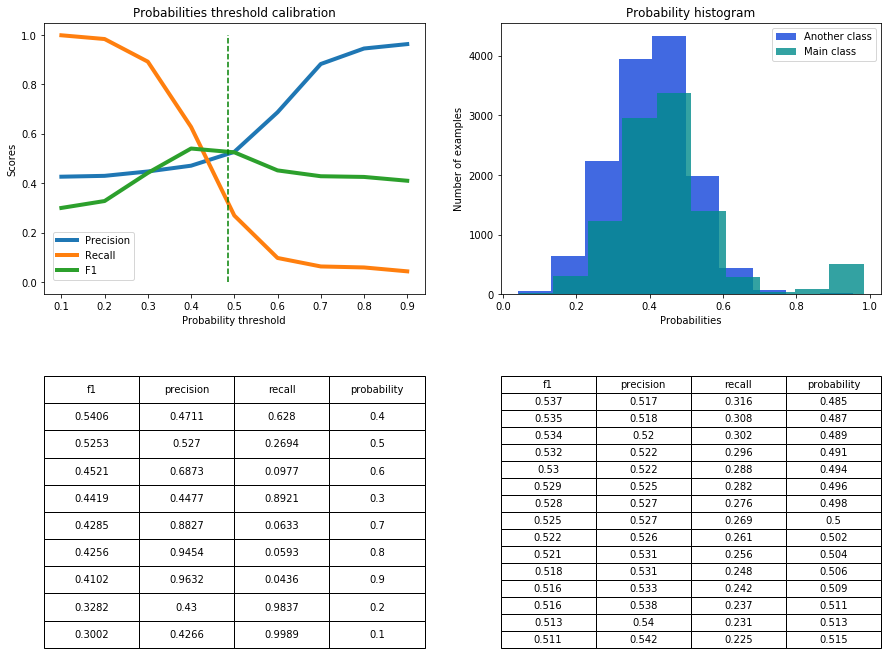

Learning rate set to 0.055408
0:	learn: 0.0000000	test: 0.0000000	test1: 0.0000000	best: 0.0000000 (0)	total: 23.3ms	remaining: 23.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3387096774
bestIteration = 384

Shrink model to first 385 iterations.
Разбивка по услуге № 7.0 (отсечка 0.5) -------------->


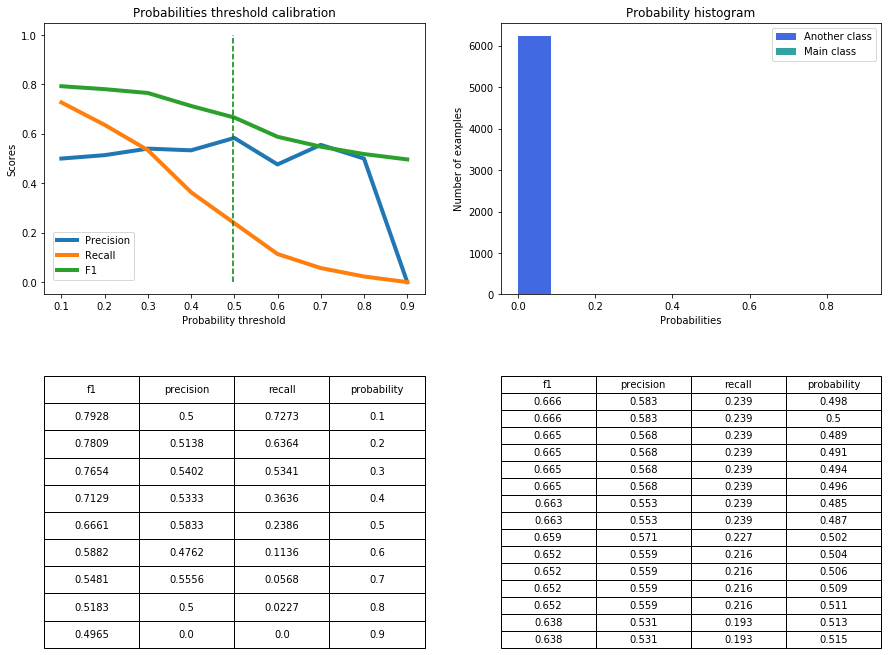

Learning rate set to 0.05342
0:	learn: 0.0000000	test: 0.0000000	test1: 0.0000000	best: 0.0000000 (0)	total: 21.6ms	remaining: 21.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7030716724
bestIteration = 161

Shrink model to first 162 iterations.
Разбивка по услуге № 8.0 (отсечка 0.5) -------------->


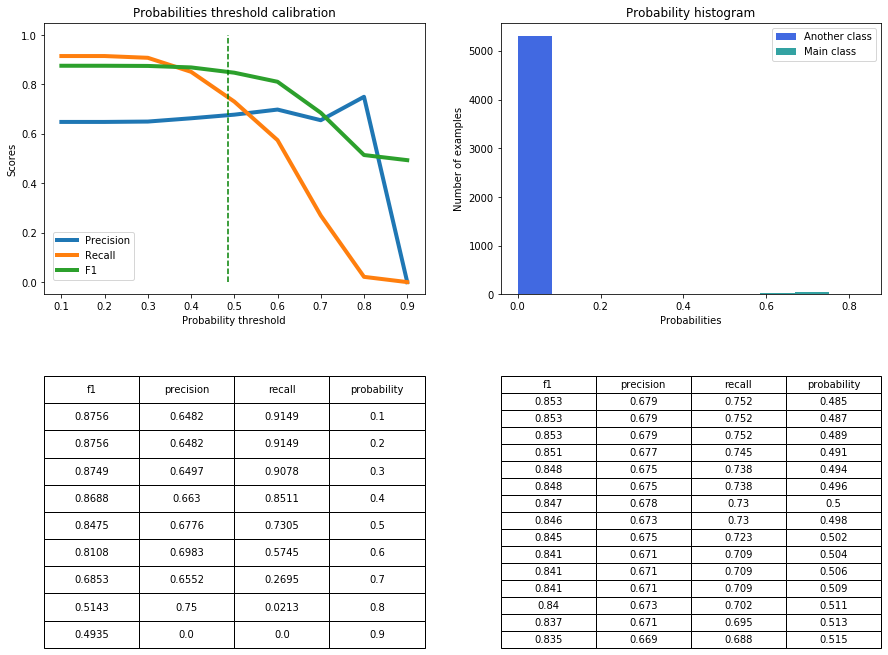

Learning rate set to 0.04287
0:	learn: 0.8804617	test: 0.8804617	test1: 0.8863920	best: 0.8863920 (0)	total: 18.4ms	remaining: 18.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.88639201
bestIteration = 0

Shrink model to first 1 iterations.
Разбивка по услуге № 9.0 (отсечка 0.5) -------------->


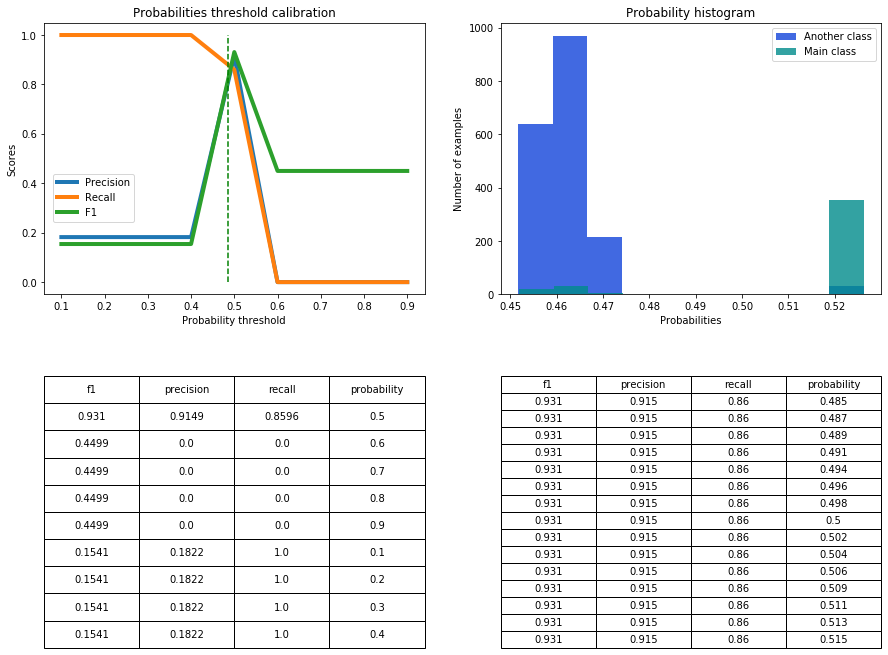

In [31]:
for ii in np.sort(df.vas_id.unique()):
    df_vas = df.copy()
    df_vas = df_vas.loc[df_vas['vas_id'] == ii]
    
    X_train, X_valid, y_train, y_valid = train_test_split(df_vas.drop('target', axis=1), df_vas['target'], 
                                                    shuffle=True,
                                                    test_size=0.4,
                                                    random_state=99,
                                                    stratify=df_vas['target']
                                                   )
    
    model_ctb = CatBoostClassifier(**cb_params)
    model_ctb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000)
    
    y_pred_cb_train = model_ctb.predict_proba(X_train)[:,1]
    y_pred_cb_valid = model_ctb.predict_proba(X_valid)[:,1]
    print(f'Разбивка по услуге № {ii} (отсечка 0.5) -------------->')
    
    show_proba_calibration_plots(y_pred_cb_valid, y_valid, focus=0.5)

In [32]:
# Как видно из результатов, разбивка по услугам в некоторых случаях повышает метрику, но в то же время в других случаях
#  она остается низкой. 
#   Среднее арифметическое f1_macro всех моделей при подборе лучшей отсечки для каждой услуги(модели) не превышает 0.77.
#    В этой связи метрика, получаемая с помощью разбивки, близка к метрике, получаемой при помощи обучения только на train.


#### Модель на первоначальных данных train в разбивке по неповторяющимся и повторяющимся id (повторные предложения тех же услуг) <a class='anchor' id='train5'>

In [33]:
train['id'].nunique(), len(train['id'])

(806613, 831653)

In [34]:
tmp_df = train.groupby(['id', 'vas_id'], as_index=False).agg({'buy_time': 'count'})
tmp_df

,id,vas_id,buy_time
0,2,2.0,1
1,4,1.0,1
2,15,1.0,1
3,16,2.0,1
4,29,1.0,1
...,...,...,...
825399,4362634,1.0,1
825400,4362640,2.0,1
825401,4362647,6.0,1
825402,4362684,5.0,1


In [35]:
tmp_df['id'].nunique()

806613

In [36]:
tmp_df.loc[tmp_df.buy_time > 1]

,id,vas_id,buy_time
130,610,8.0,2
165,771,4.0,2
230,1168,4.0,2
306,1559,4.0,2
310,1582,4.0,2
...,...,...,...
798467,4217743,1.0,2
803476,4244393,1.0,2
808261,4270769,1.0,2
808340,4271145,6.0,2


In [37]:
# В train ДАТАСЕТЕ НЕТ ТЕХ КЛИЕНТОВ, КОТОРЫМ ОДНА УСЛУГА ПРЕДЛАГАСЬ БОЛЬШЕ 2-х РАЗ.
# <----------

In [38]:
# Этим клиентам услуга предлагалась дважды
repeat_offers = train.loc[(train.id.isin(tmp_df.loc[tmp_df.buy_time > 1]['id'].tolist()))]
repeat_offers

,id,vas_id,buy_time,target
52,675583,2.0,1535317200,0.0
53,675583,2.0,1542574800,1.0
92,1825537,4.0,1532898000,1.0
93,1825537,4.0,1544389200,0.0
322,1010292,1.0,1535317200,0.0
...,...,...,...,...
829444,1498547,6.0,1544994000,1.0
829813,135601,6.0,1544994000,0.0
829814,135601,6.0,1546203600,1.0
829906,428413,6.0,1544994000,0.0


In [39]:
# Этим клиентам услуга предлагалась единожды
not_repeat_offers = train.loc[(~train.id.isin(tmp_df.loc[tmp_df.buy_time > 1]['id'].tolist()))]
not_repeat_offers

,id,vas_id,buy_time,target
0,540968,8.0,1537131600,0.0
1,1454121,4.0,1531688400,0.0
2,2458816,1.0,1534107600,0.0
3,3535012,5.0,1535922000,0.0
4,1693214,1.0,1535922000,0.0
...,...,...,...,...
831648,3812226,2.0,1546203600,0.0
831649,2480469,2.0,1546203600,0.0
831650,158236,2.0,1546203600,0.0
831651,1825525,2.0,1546203600,0.0


In [40]:
repeat_offers.target.value_counts()

1.0    6290
0.0    6221
Name: target, dtype: int64

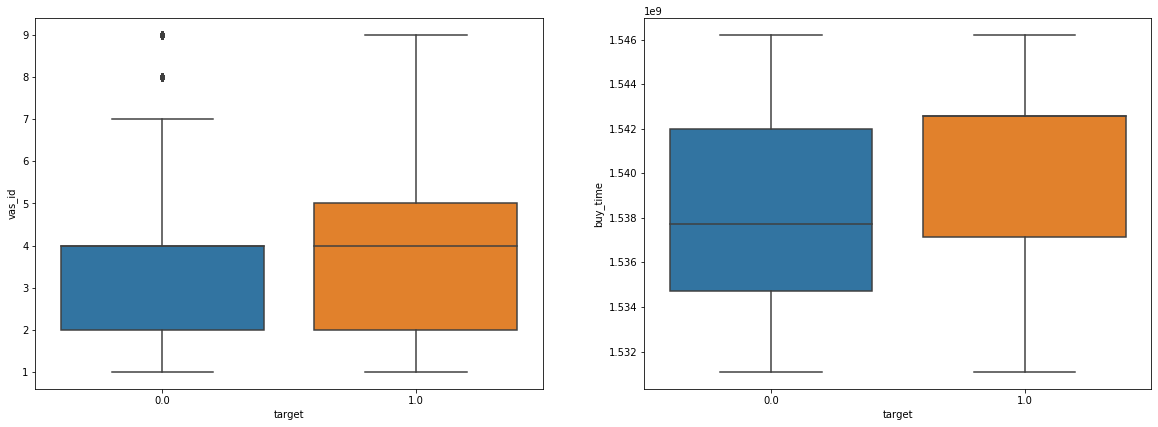

In [41]:
plt.figure(figsize = (20, 15))
for num, feature in enumerate(repeat_offers[['vas_id', 'buy_time']].columns.tolist(), start=1):
    plt.subplot(2, 2, num)
    sns.boxplot(x=repeat_offers['target'], y=feature, data=repeat_offers)

Learning rate set to 0.146458
0:	learn: 0.0535564	test: 0.0535564	test1: 0.0515664	best: 0.0515664 (0)	total: 90ms	remaining: 1m 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3597141793
bestIteration = 160

Shrink model to first 161 iterations.


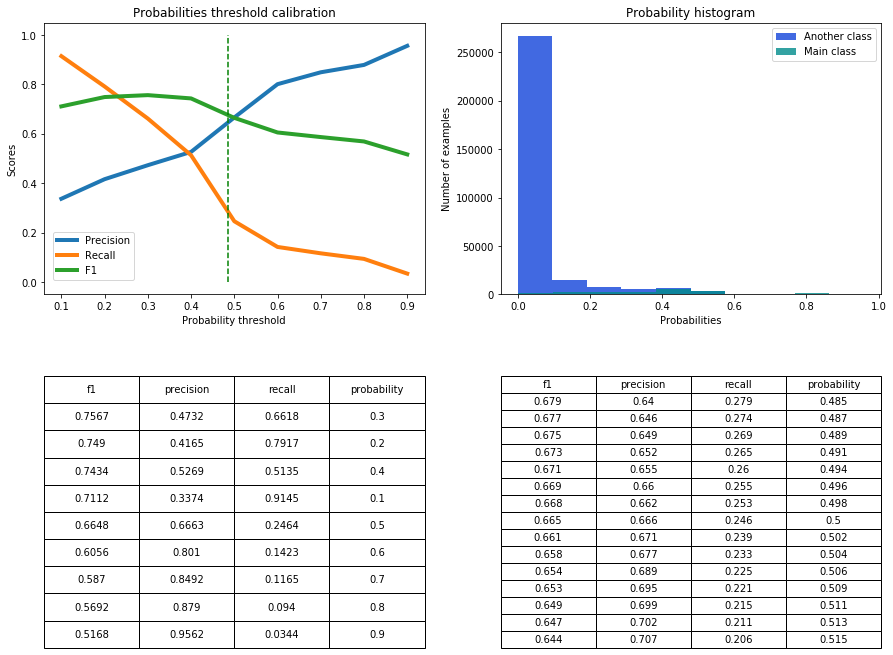

0.485

In [42]:
X_train_not, X_valid_not, y_train_not, y_valid_not = train_test_split(not_repeat_offers.drop('target', axis=1),
                                                                     not_repeat_offers['target'], 
                                                    shuffle=True,
                                                    test_size=0.4,
                                                    random_state=99,
                                                    stratify=not_repeat_offers['target']
                                                   )
    
model_ctb_not = CatBoostClassifier(**cb_params)
model_ctb_not.fit(X_train_not, y_train_not, eval_set=[(X_train_not, y_train_not), (X_valid_not, y_valid_not)], verbose=1000)
    
y_pred_cb_train_not = model_ctb_not.predict_proba(X_train_not)[:,1]
y_pred_cb_valid_not = model_ctb_not.predict_proba(X_valid_not)[:,1]
  
show_proba_calibration_plots(y_pred_cb_valid_not, y_valid_not, focus=0.5)

Learning rate set to 0.052136
0:	learn: 0.6097872	test: 0.6097872	test1: 0.6077469	best: 0.6077469 (0)	total: 6.02ms	remaining: 6.01s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6837177438
bestIteration = 217

Shrink model to first 218 iterations.


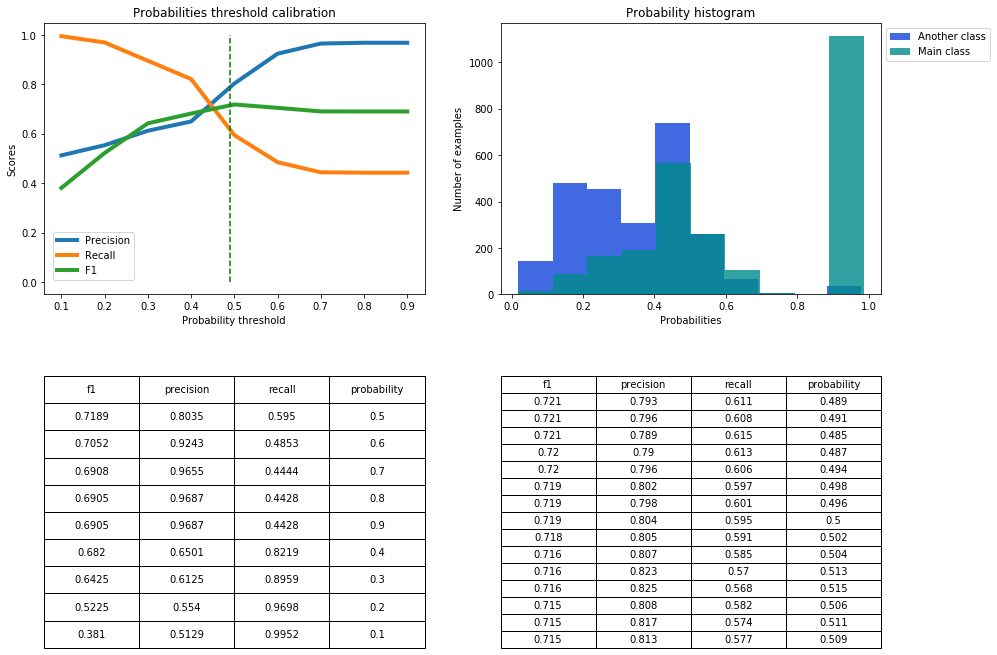

0.489

In [43]:
X_train_is, X_valid_is, y_train_is, y_valid_is = train_test_split(repeat_offers.drop('target', axis=1),
                                                                     repeat_offers['target'], 
                                                    shuffle=True,
                                                    test_size=0.4,
                                                    random_state=99,
                                                    stratify=repeat_offers['target']
                                                   )
    
model_ctb_is = CatBoostClassifier(**cb_params)
model_ctb_is.fit(X_train_is, y_train_is, eval_set=[(X_train_is, y_train_is), (X_valid_is, y_valid_is)], verbose=1000)
    
y_pred_cb_train_is = model_ctb_is.predict_proba(X_train_is)[:,1]
y_pred_cb_valid_is = model_ctb_is.predict_proba(X_valid_is)[:,1]
  
show_proba_calibration_plots(y_pred_cb_valid_is, y_valid_is, focus=0.5)

In [44]:
# Данная разбивка также не дает прироста в качестве

In [45]:
# Дополнительно исследуем датасет repeat_offers

In [46]:
repeat_offers3 = repeat_offers.copy()

In [47]:
# max
tmp1_repeat_offers3 = repeat_offers3.groupby(['id', 'vas_id'], as_index=False).agg({'buy_time': 'max'})

tmp_max_repeat_offers = pd.merge(tmp1_repeat_offers3, repeat_offers3, on=['id', 'vas_id', 'buy_time'], how='left')
tmp_max_repeat_offers

,id,vas_id,buy_time,target
0,610,8.0,1542574800,1.0
1,771,4.0,1536526800,1.0
2,1168,4.0,1543179600,0.0
3,1559,4.0,1532293200,1.0
4,1582,4.0,1532898000,0.0
...,...,...,...,...
6257,4217743,1.0,1542574800,1.0
6258,4244393,1.0,1537736400,1.0
6259,4270769,1.0,1536526800,0.0
6260,4271145,6.0,1543784400,1.0


In [48]:
# min
tmp1_repeat_offers4 = repeat_offers3.groupby(['id', 'vas_id'], as_index=False).agg({'buy_time': 'min'})

tmp_min_repeat_offers = pd.merge(tmp1_repeat_offers4, repeat_offers3, on=['id', 'vas_id', 'buy_time'], how='left')
tmp_min_repeat_offers

,id,vas_id,buy_time,target
0,610,8.0,1535317200,0.0
1,771,4.0,1531083600,0.0
2,1168,4.0,1542574800,1.0
3,1559,4.0,1531688400,0.0
4,1582,4.0,1531688400,1.0
...,...,...,...,...
6257,4217743,1.0,1533502800,0.0
6258,4244393,1.0,1532293200,0.0
6259,4270769,1.0,1532293200,1.0
6260,4271145,6.0,1543179600,0.0


In [49]:
tmp_max_repeat_offers['target'].value_counts()

1.0    4091
0.0    2171
Name: target, dtype: int64

In [50]:
tmp_min_repeat_offers['target'].value_counts()

0.0    4057
1.0    2205
Name: target, dtype: int64

In [51]:
# Это говорит о том, что при повторном предложении услуги половина клиентов из ранее отказавшихся всё-таки подключили услугу
# <----------

In [52]:
# 0-0 или 1-1
identical_status_repeat_offers = repeat_offers.groupby(['id', 'target'], as_index=False).agg({'buy_time': 'count'})

identical_status_repeat_offers

,id,target,buy_time
0,610,0.0,1
1,610,1.0,1
2,771,0.0,1
3,771,1.0,1
4,1168,0.0,1
...,...,...,...
12456,4270769,1.0,1
12457,4271145,0.0,1
12458,4271145,1.0,1
12459,4339012,0.0,1


In [54]:
# 1-1
# КЛИЕНТЫ, КОТОРЫЕ 2 РАЗА ПОДКЛЮЧИЛИ ОДНУ И ТУ ЖЕ УСЛУГУ(БЕЗ ОТКЮЧЕНИЯ) (возможно это выбросы или некорректные данные)
identical_status_repeat_offers.loc[(identical_status_repeat_offers['buy_time'] > 1) &\
                                   (identical_status_repeat_offers['target'] == 1)].head()

,id,target,buy_time
918,176126,1.0,2
1057,197115,1.0,2
1362,251445,1.0,2
1451,267605,1.0,2
1502,280920,1.0,2


In [55]:
# Дополнительно построим модель для train с разбивкой признака buy_time

In [56]:
train2 = train.copy()

In [57]:
train2['year'] = pd.to_datetime([ii for ii in train2['buy_time']], unit='s').year
train2['month'] = pd.to_datetime([ii for ii in train2['buy_time']], unit='s').month
train2['day'] = pd.to_datetime([ii for ii in train2['buy_time']], unit='s').day
train2['dayofweek'] = pd.to_datetime([ii for ii in train2['buy_time']], unit='s').dayofweek

In [58]:
train2.head()

,id,vas_id,buy_time,target,year,month,day,dayofweek
0,540968,8.0,1537131600,0.0,2018,9,16,6
1,1454121,4.0,1531688400,0.0,2018,7,15,6
2,2458816,1.0,1534107600,0.0,2018,8,12,6
3,3535012,5.0,1535922000,0.0,2018,9,2,6
4,1693214,1.0,1535922000,0.0,2018,9,2,6


In [59]:
train2.dayofweek.value_counts()

# услуга предлагалась в воскресенье

6    831653
Name: dayofweek, dtype: int64

In [60]:
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(train2.drop('target', axis=1), train2['target'], 
                                                    shuffle=True,
                                                    test_size=0.4,
                                                    random_state=99,
                                                    stratify=train2['target']
                                                   )

In [61]:
model_ctb_ = CatBoostClassifier(**cb_params)
model_ctb_.fit(X_train_, y_train_, eval_set=[(X_train_, y_train_), (X_valid_, y_valid_)], verbose=100)

Learning rate set to 0.147007
0:	learn: 0.0979021	test: 0.0979021	test1: 0.1029367	best: 0.1029367 (0)	total: 91.1ms	remaining: 1m 31s
100:	learn: 0.3926584	test: 0.3926584	test1: 0.3815392	best: 0.3849050 (57)	total: 8.48s	remaining: 1m 15s
200:	learn: 0.4064023	test: 0.4064023	test1: 0.3914668	best: 0.3916343 (155)	total: 17s	remaining: 1m 7s
300:	learn: 0.4125470	test: 0.4125470	test1: 0.3937454	best: 0.3957896 (270)	total: 26.4s	remaining: 1m 1s
400:	learn: 0.4171232	test: 0.4171232	test1: 0.3970088	best: 0.3970443 (390)	total: 36.1s	remaining: 53.9s
500:	learn: 0.4225838	test: 0.4225838	test1: 0.3992138	best: 0.3992138 (500)	total: 45.4s	remaining: 45.2s
600:	learn: 0.4271685	test: 0.4271685	test1: 0.4013580	best: 0.4016681 (586)	total: 54.9s	remaining: 36.4s
700:	learn: 0.4315170	test: 0.4315170	test1: 0.4033440	best: 0.4042918 (656)	total: 1m 4s	remaining: 27.5s
800:	learn: 0.4348452	test: 0.4348452	test1: 0.4049160	best: 0.4067314 (754)	total: 1m 13s	remaining: 18.3s
Stopped by

In [62]:
y_pred_train_ = model_ctb_.predict(X_train_)
y_pred_valid_ = model_ctb_.predict(X_valid_)
print(f" {get_classification_report(y_train_, y_pred_train_, y_valid_, y_pred_valid_, threshold=0.3)}")

TRAIN

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    462879
         1.0       0.69      0.32      0.43     36112

    accuracy                           0.94    498991
   macro avg       0.82      0.65      0.70    498991
weighted avg       0.93      0.94      0.93    498991

TEST

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    308588
         1.0       0.65      0.30      0.41     24074

    accuracy                           0.94    332662
   macro avg       0.80      0.64      0.69    332662
weighted avg       0.93      0.94      0.93    332662

 None


In [64]:
# данная разбивка признака buy_time также не дала прироста качества.

#### Модель на первоначальных данных train и сэмплирование классов <a class='anchor' id='train6'>

In [65]:
y = train['target']

X_train_and_test, X_part = train_test_split(train, train_size=0.8, random_state=99, stratify=y)

X_train_and_test.shape

(665322, 4)

In [66]:
%%time
# Попробуем поправить вручную дисбаланс классов и обучить модель.
target_counts = X_train_and_test['target'].value_counts()
target_counts

major_class_name = target_counts.argmax()
major_class_name
# выдаст 0
minor_class_name = target_counts.argmin()
minor_class_name
# выдаст 1

disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
# выдаст 1 >>>>  int(2.549455750118315) - 1

for i in tqdm(range(disbalance_coeff)):
        sample = X_train_and_test[X_train_and_test['target'] == minor_class_name].sample(target_counts[minor_class_name])
        X_train_and_test = X_train_and_test.append(sample, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 10.94it/s]

Wall time: 1.05 s


In [67]:
X_train_and_test['target'].value_counts()

0.0    617173
1.0    577788
Name: target, dtype: int64

In [68]:
X_train_s, X_valid_s, y_train_s, y_valid_s = train_test_split(X_train_and_test.drop('target', axis=1), X_train_and_test['target'], 
                                                    shuffle=True,
                                                    test_size=0.4,
                                                    random_state=99,
                                                    stratify=X_train_and_test['target']
                                                   )

In [69]:
model_ctb_s = CatBoostClassifier(**cb_params)
model_ctb_s.fit(X_train_s, y_train_s, eval_set=[(X_train_s, y_train_s), (X_valid_s, y_valid_s)], verbose=100)

Learning rate set to 0.160775
0:	learn: 0.8675571	test: 0.8675571	test1: 0.8678623	best: 0.8678623 (0)	total: 121ms	remaining: 2m
100:	learn: 0.8872066	test: 0.8872066	test1: 0.8876769	best: 0.8876769 (99)	total: 11.4s	remaining: 1m 41s
200:	learn: 0.8874623	test: 0.8874623	test1: 0.8878118	best: 0.8878235 (197)	total: 23.6s	remaining: 1m 33s
300:	learn: 0.8876476	test: 0.8876476	test1: 0.8879261	best: 0.8879477 (295)	total: 35.7s	remaining: 1m 22s
400:	learn: 0.8880172	test: 0.8880172	test1: 0.8881904	best: 0.8882035 (396)	total: 48.4s	remaining: 1m 12s
500:	learn: 0.8882684	test: 0.8882684	test1: 0.8883262	best: 0.8883262 (500)	total: 1m	remaining: 1m
600:	learn: 0.8884577	test: 0.8884577	test1: 0.8884616	best: 0.8884616 (600)	total: 1m 12s	remaining: 48.3s
700:	learn: 0.8887752	test: 0.8887752	test1: 0.8886987	best: 0.8886987 (700)	total: 1m 24s	remaining: 36.2s
800:	learn: 0.8888945	test: 0.8888945	test1: 0.8887319	best: 0.8887605 (759)	total: 1m 36s	remaining: 24.1s
900:	learn: 0.

TRAIN

              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89    246870
         1.0       0.87      0.91      0.89    231115

    accuracy                           0.89    477985
   macro avg       0.89      0.89      0.89    477985
weighted avg       0.89      0.89      0.89    477985

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    154294
         1.0       0.35      0.90      0.51     12037

    accuracy                           0.87    166331
   macro avg       0.67      0.89      0.72    166331
weighted avg       0.95      0.87      0.90    166331

 None


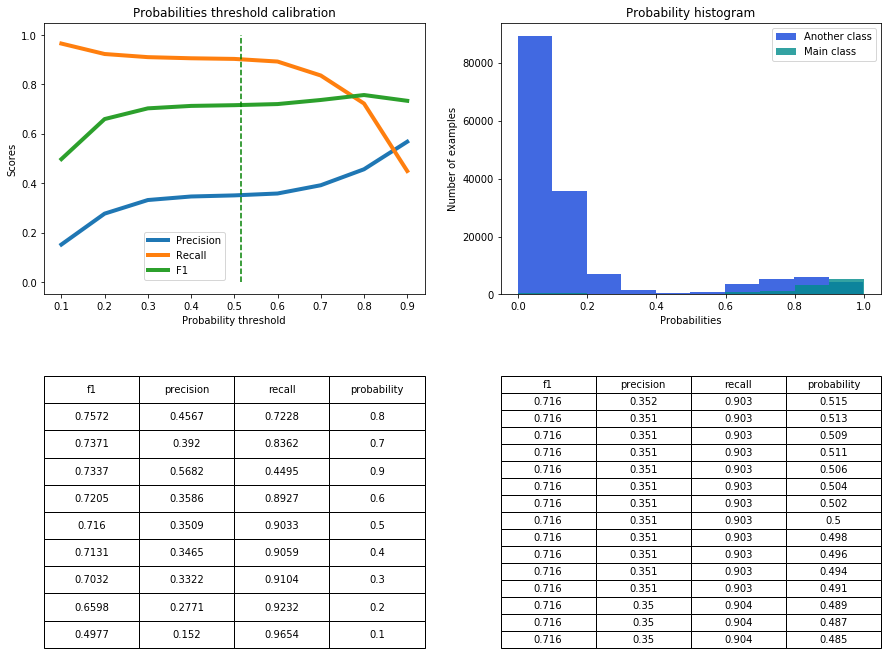

0.515

In [70]:
y_pred_cb_valid_s = model_ctb_s.predict_proba(X_valid_s)[:,1]
y_pred_cb_test_s = model_ctb_s.predict_proba(X_part.drop('target', axis=1))[:,1]

print(f" {get_classification_report(y_valid_s, y_pred_cb_valid_s, X_part['target'], y_pred_cb_test_s, threshold=0.5)}")
show_proba_calibration_plots(y_pred_cb_test_s, X_part['target'], focus=0.5)

In [71]:
# Сэмплирование не дало прироста качества на отложенной выборке.

### Подбор гиперпараметров модели <a class='anchor' id='hyper'>

In [72]:
# За основу принят базовый датасет train.

In [74]:
params_ctb = {
    "n_estimators": 1000,
#     "loss_function": "Logloss",
    "eval_metric": "F1",
    "task_type": "CPU",
#     "max_bin": 20,
#     "verbose": 25,
#     "max_depth": 6,
#     "l2_leaf_reg": 100,
#     "early_stopping_rounds": 50,
#     "thread_count": 6,
    "random_seed": 99
}

In [82]:
X_train, X_valid, y_train, y_valid = train_test_split(train.drop('target', axis=1), train['target'], 
                                                    shuffle=True,
                                                    test_size=0.4,
                                                    random_state=99,
                                                    stratify=train['target']
                                                   )

In [84]:
def catboost_optimize_params(
    n_estimators,
    max_depth,
#     learning_rate,
#     l2_leaf_reg,
#     max_bin,
#     thread_count,
#     min_child_samples,
#     subsample
):
    params_ctb["n_estimators"]= int(n_estimators)
    params_ctb["max_depth"] = int(max_depth)
#     params_ctb["learning_rate"] = learning_rate
#     params_ctb["l2_leaf_reg"]= int(l2_leaf_reg)
#     params_ctb["max_bin"]= int(max_bin)
#     params_ctb["thread_count"]= int(thread_count)
#     params_ctb["min_child_samples"]= int(min_child_samples)
#     params_ctb["subsample"] = subsample

    model_ctb_new = CatBoostClassifier(**params_ctb)
    model_ctb_new.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=False)

    return f1_score(y_valid, model_ctb_new.predict(X_valid), average='macro')

In [86]:
ctb_params_search = BayesianOptimization(
    f=catboost_optimize_params,
    pbounds={
        "n_estimators": (50, 2500),
        "max_depth": (2, 10),
#         'learning_rate': (0.01, 0.9),
#         "l2_leaf_reg": (1, 300),
#         "max_bin": (1, 350),
#         "thread_count": (1, 30),
#         'min_child_samples': (1, 250),
#         'subsample': (0.2, 0.8)
    },
    random_state=99
)

ctb_params_search.maximize(init_points=3, n_iter=3, acq='ei')

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
|  1        |  0.6817   |  7.378    |  1.246e+0 |
|  2        |  0.6779   |  8.604    |  127.0    |
|  3        |  0.6816   |  8.464    |  1.436e+0 |
|  4        |  0.6823   |  6.756    |  2.5e+03  |
|  5        |  0.6697   |  2.725    |  2.498e+0 |
|  6        |  0.679    |  10.0     |  628.3    |


### Сохранение модели, прогноз на тестовой выборке <a class='anchor' id='train_save'>

In [87]:
class ColumnSelector(BaseEstimator, TransformerMixin):

    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [88]:
class DataPreprocessing(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.X = None
#         self.X_train = X_train
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        return self

    def transform(self, X):
        """Трансформация данных"""
        
        if (X.isna().sum().values).sum() > 0:
            X.fillna(0, inplace=True)
            print('ДОПОЛНИТЕЛЬНО БЫЛИ ЗАМЕНЕНЫ ПУСТЫЕ ЯЧЕЙКИ НА 0')
        
        return X

In [91]:
pipeline = Pipeline([("preprocessor", DataPreprocessing()),
                    ('selector', ColumnSelector(key=['id', 'vas_id', 'buy_time'])),
    ('classifier', CatBoostClassifier(**cb_params, verbose=1000)),
])

pipeline.fit(X_train, y_train)

Learning rate set to 0.146224
0:	learn: 0.0484914	total: 80.9ms	remaining: 1m 20s
999:	learn: 0.4338574	total: 1m 23s	remaining: 0us


Pipeline(memory=None,
         steps=[('preprocessor', DataPreprocessing()),
                ('selector', ColumnSelector(key=['id', 'vas_id', 'buy_time'])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x0000019106449788>)],
         verbose=False)

In [92]:
with open("ctb_model_pipeline.pickle", "wb") as file1:
    pickle.dump(pipeline, file1)
with open("ctb_model.pickle", "wb") as file2:
    pickle.dump(model_ctb, file2)

In [93]:
with open("ctb_model_pipeline.pickle", "rb") as f1:
    loading_pipe = pickle.load(f1)

In [99]:
test = DataPreprocessing().transform(test)

In [100]:
predictions = loading_pipe.predict_proba(test)[:, 1]
predictions

array([2.14062557e-07, 2.61838051e-01, 2.52605823e-07, ...,
       3.12122462e-07, 1.07330484e-07, 2.50659755e-07])

In [101]:
test['target'] = predictions.round(5)
test

,id,vas_id,buy_time,target
0,3130519,2.0,1548018000,0.00000
1,2000860,4.0,1548018000,0.26184
2,1099444,2.0,1546808400,0.00000
3,1343255,5.0,1547413200,0.00002
4,1277040,2.0,1546808400,0.00000
...,...,...,...,...
71226,2502453,5.0,1548018000,0.00002
71227,1693213,2.0,1548018000,0.00000
71228,1891350,2.0,1548018000,0.00000
71229,2437172,2.0,1548018000,0.00000


In [97]:
test.to_csv('answers_test.csv', index=False)

In [98]:
!pip freeze > requirements.txt